#### Assignment 2: Computer Vision 2

#### Imports

In [269]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from packaging import version
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from tensorflow.keras.regularizers import l1, l2

from sklearn.manifold import TSNE
from keras.models import Model

#### EDA Functions

In [22]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

#### Research Functions

In [24]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#### Model and Performance Functions

In [27]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, epochs=200):
  timestamp=int(time.time())

  # Compile
  model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
        ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        ]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x_train, y_train)

  print('Evaluating model performance with validation set')
  model.evaluate(x_valid, y_valid)

  return history, model

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#### Import the CIFAR-10 Data Set

In [31]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [32]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [33]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

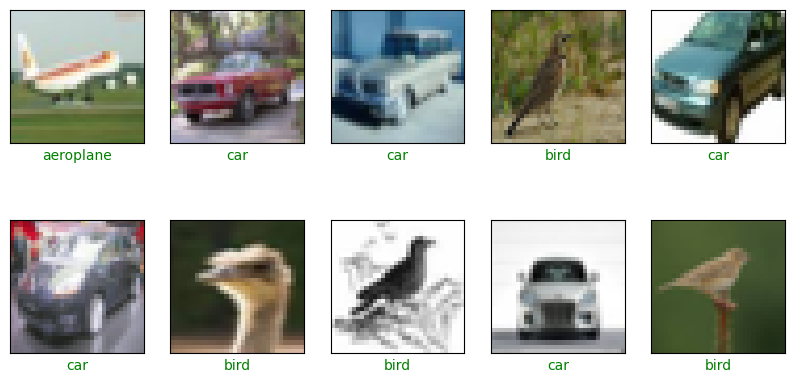

In [34]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

#### Pre-Processing

In [35]:
# Create validation set
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [36]:
# Rescale
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

#### Experiment 1 - Dense Neural Network, 2 Layers, No Regularaziation

In [91]:
model_one = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_one.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_one = model_one.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_one = tf.keras.models.load_model("model_one.h5")

pred_one = model_one.predict(x_test_norm)

pred_one = np.argmax(pred_one, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 471us/step


#### Experiment 2 - Dense Neural Network, 3 Layers, No Regularization

In [92]:
model_two = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=512,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_two.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_two = model_two.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_two = tf.keras.models.load_model("model_two.h5")

pred_two = model_two.predict(x_test_norm)

pred_two = np.argmax(pred_two, axis=1)

313/313 [==============================] - 0s 661us/step


#### Experiment 3 - Convolutional Neural Network, 2 Convolutional & Max Pooling Layers, No Regularization

In [93]:
model_three = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_three = model_three.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_three = tf.keras.models.load_model("model_three.h5")

pred_three = model_three.predict(x_test_norm)

pred_three = np.argmax(pred_three, axis=1)

313/313 [==============================] - 1s 4ms/step


#### Experiment 4 - Convolutional Neural Network, 3 Convolutional & Max Pooling Layers, No Regularization

In [94]:
model_four = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_four.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_four = model_four.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_four = tf.keras.models.load_model("model_four.h5")

pred_four = model_four.predict(x_test_norm)

pred_four = np.argmax(pred_four, axis=1)

313/313 [==============================] - 2s 5ms/step


#### Experiment 5

In [96]:
model_five = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_five.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_five = model_five.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_five = tf.keras.models.load_model("model_five.h5")

pred_five = model_five.predict(x_test_norm)

pred_five = np.argmax(pred_five, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 532us/step


#### Experiment 6

In [97]:
model_six = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=512,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_six.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_six = model_six.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_six = tf.keras.models.load_model("model_six.h5")

pred_six = model_six.predict(x_test_norm)

pred_six = np.argmax(pred_six, axis=1)

313/313 [==============================] - 0s 743us/step


#### Experiment 7

In [98]:
model_seven = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)        
])

model_seven.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_seven = model_seven.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_seven = tf.keras.models.load_model("model_seven.h5")

pred_seven = model_seven.predict(x_test_norm)

pred_seven = np.argmax(pred_seven, axis=1)

313/313 [==============================] - 1s 4ms/step


#### Experiment 8

In [99]:
model_eight = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)   
])

model_eight.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_eight = model_eight.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_eight = tf.keras.models.load_model("model_eight.h5")

pred_eight = model_eight.predict(x_test_norm)

pred_eight = np.argmax(pred_eight, axis=1)

313/313 [==============================] - 2s 5ms/step


#### Experiment 9

In [101]:
model_nine = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)     
])

model_nine.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_nine = model_nine.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_nine.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_nine = tf.keras.models.load_model("model_nine.h5")

pred_nine = model_nine.predict(x_test_norm)

pred_nine = np.argmax(pred_nine, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 4s 12ms/step


#### Experiment 10

In [105]:
model_ten = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)         
])

model_ten.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_ten = model_ten.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_ten.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_ten = tf.keras.models.load_model("model_ten.h5")

pred_ten = model_ten.predict(x_test_norm)

pred_ten = np.argmax(pred_ten, axis=1)

313/313 [==============================] - 1s 3ms/step


#### Results

In [ ]:
def create_results_dataframe(model_name,training_history,y_true,y_pred):

    training_df = pd.DataFrame(training_history.history)
    model_results_df = pd.DataFrame(training_df.iloc[-1,:]).transpose()
    model_results_df = model_results_df.reset_index().rename(columns={'index':'epoch'})
    model_results_df['model'] = model_name
    model_results_df = model_results_df.iloc[:,[-1,0,1,2]]
    model_results_df['precision_micro'] = precision_score(y_true,y_pred,average='micro')
    model_results_df['recall_micro'] = recall_score(y_true,y_pred,average='micro')
    model_results_df['f1_score_micro'] = f1_score(y_true,y_pred,average='micro')

    return(model_results_df)

In [144]:
experiment_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])

experiment_1_results = create_results_dataframe('model_one',training_one,y_test,pred_one)
experiment_2_results = create_results_dataframe('model_two',training_two,y_test,pred_two)
experiment_3_results = create_results_dataframe('model_three',training_three,y_test,pred_three)
experiment_4_results = create_results_dataframe('model_four',training_four,y_test,pred_four)
experiment_5_results = create_results_dataframe('model_five',training_five,y_test,pred_five)
experiment_6_results = create_results_dataframe('model_six',training_six,y_test,pred_six)
experiment_7_results = create_results_dataframe('model_seven',training_seven,y_test,pred_seven)
experiment_8_results = create_results_dataframe('model_eight',training_eight,y_test,pred_eight)
experiment_9_results = create_results_dataframe('model_nine',training_nine,y_test,pred_nine)
experiment_10_results = create_results_dataframe('model_ten',training_ten,y_test,pred_ten)

experiment_results = pd.concat([
    experiment_1_results,
    experiment_2_results,
    experiment_3_results,
    experiment_4_results,
    experiment_5_results,
    experiment_6_results,
    experiment_7_results,
    experiment_8_results,
    experiment_9_results,
    experiment_10_results
    ]).reset_index(drop=True)
    
experiment_results

,model,epoch,loss,accuracy,precision_micro,recall_micro,f1_score_micro
0,model_one,22,1.394315,0.509311,0.4732,0.4732,0.4732
1,model_two,18,1.241244,0.557089,0.4912,0.4912,0.4912
2,model_three,15,0.075686,0.974622,0.7127,0.7127,0.7127
3,model_four,15,0.142627,0.949689,0.7409,0.7409,0.7409
4,model_five,11,1.690377,0.399956,0.4255,0.4255,0.4255
5,model_six,13,1.527836,0.457222,0.4647,0.4647,0.4647
6,model_seven,33,0.382135,0.863933,0.7648,0.7648,0.7648
7,model_eight,35,0.540178,0.811533,0.8035,0.8035,0.8035
8,model_nine,12,0.132021,0.953600,0.7344,0.7344,0.7344
9,model_ten,13,0.126208,0.957844,0.7078,0.7078,0.7078


In [209]:
def plot_confusion_matrices(y_preds, y_true):
    num_sets = len(y_preds)
    cols = min(4, num_sets)
    rows = (num_sets + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)

    for i, (y_pred, ax) in enumerate(zip(y_preds, axs.flat)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(f"Model {i+1}")

    # Remove any empty subplots in the bottom row
    for i in range(num_sets, rows * cols):
        axs.flat[i].axis("off")

    plt.tight_layout()
    plt.show()

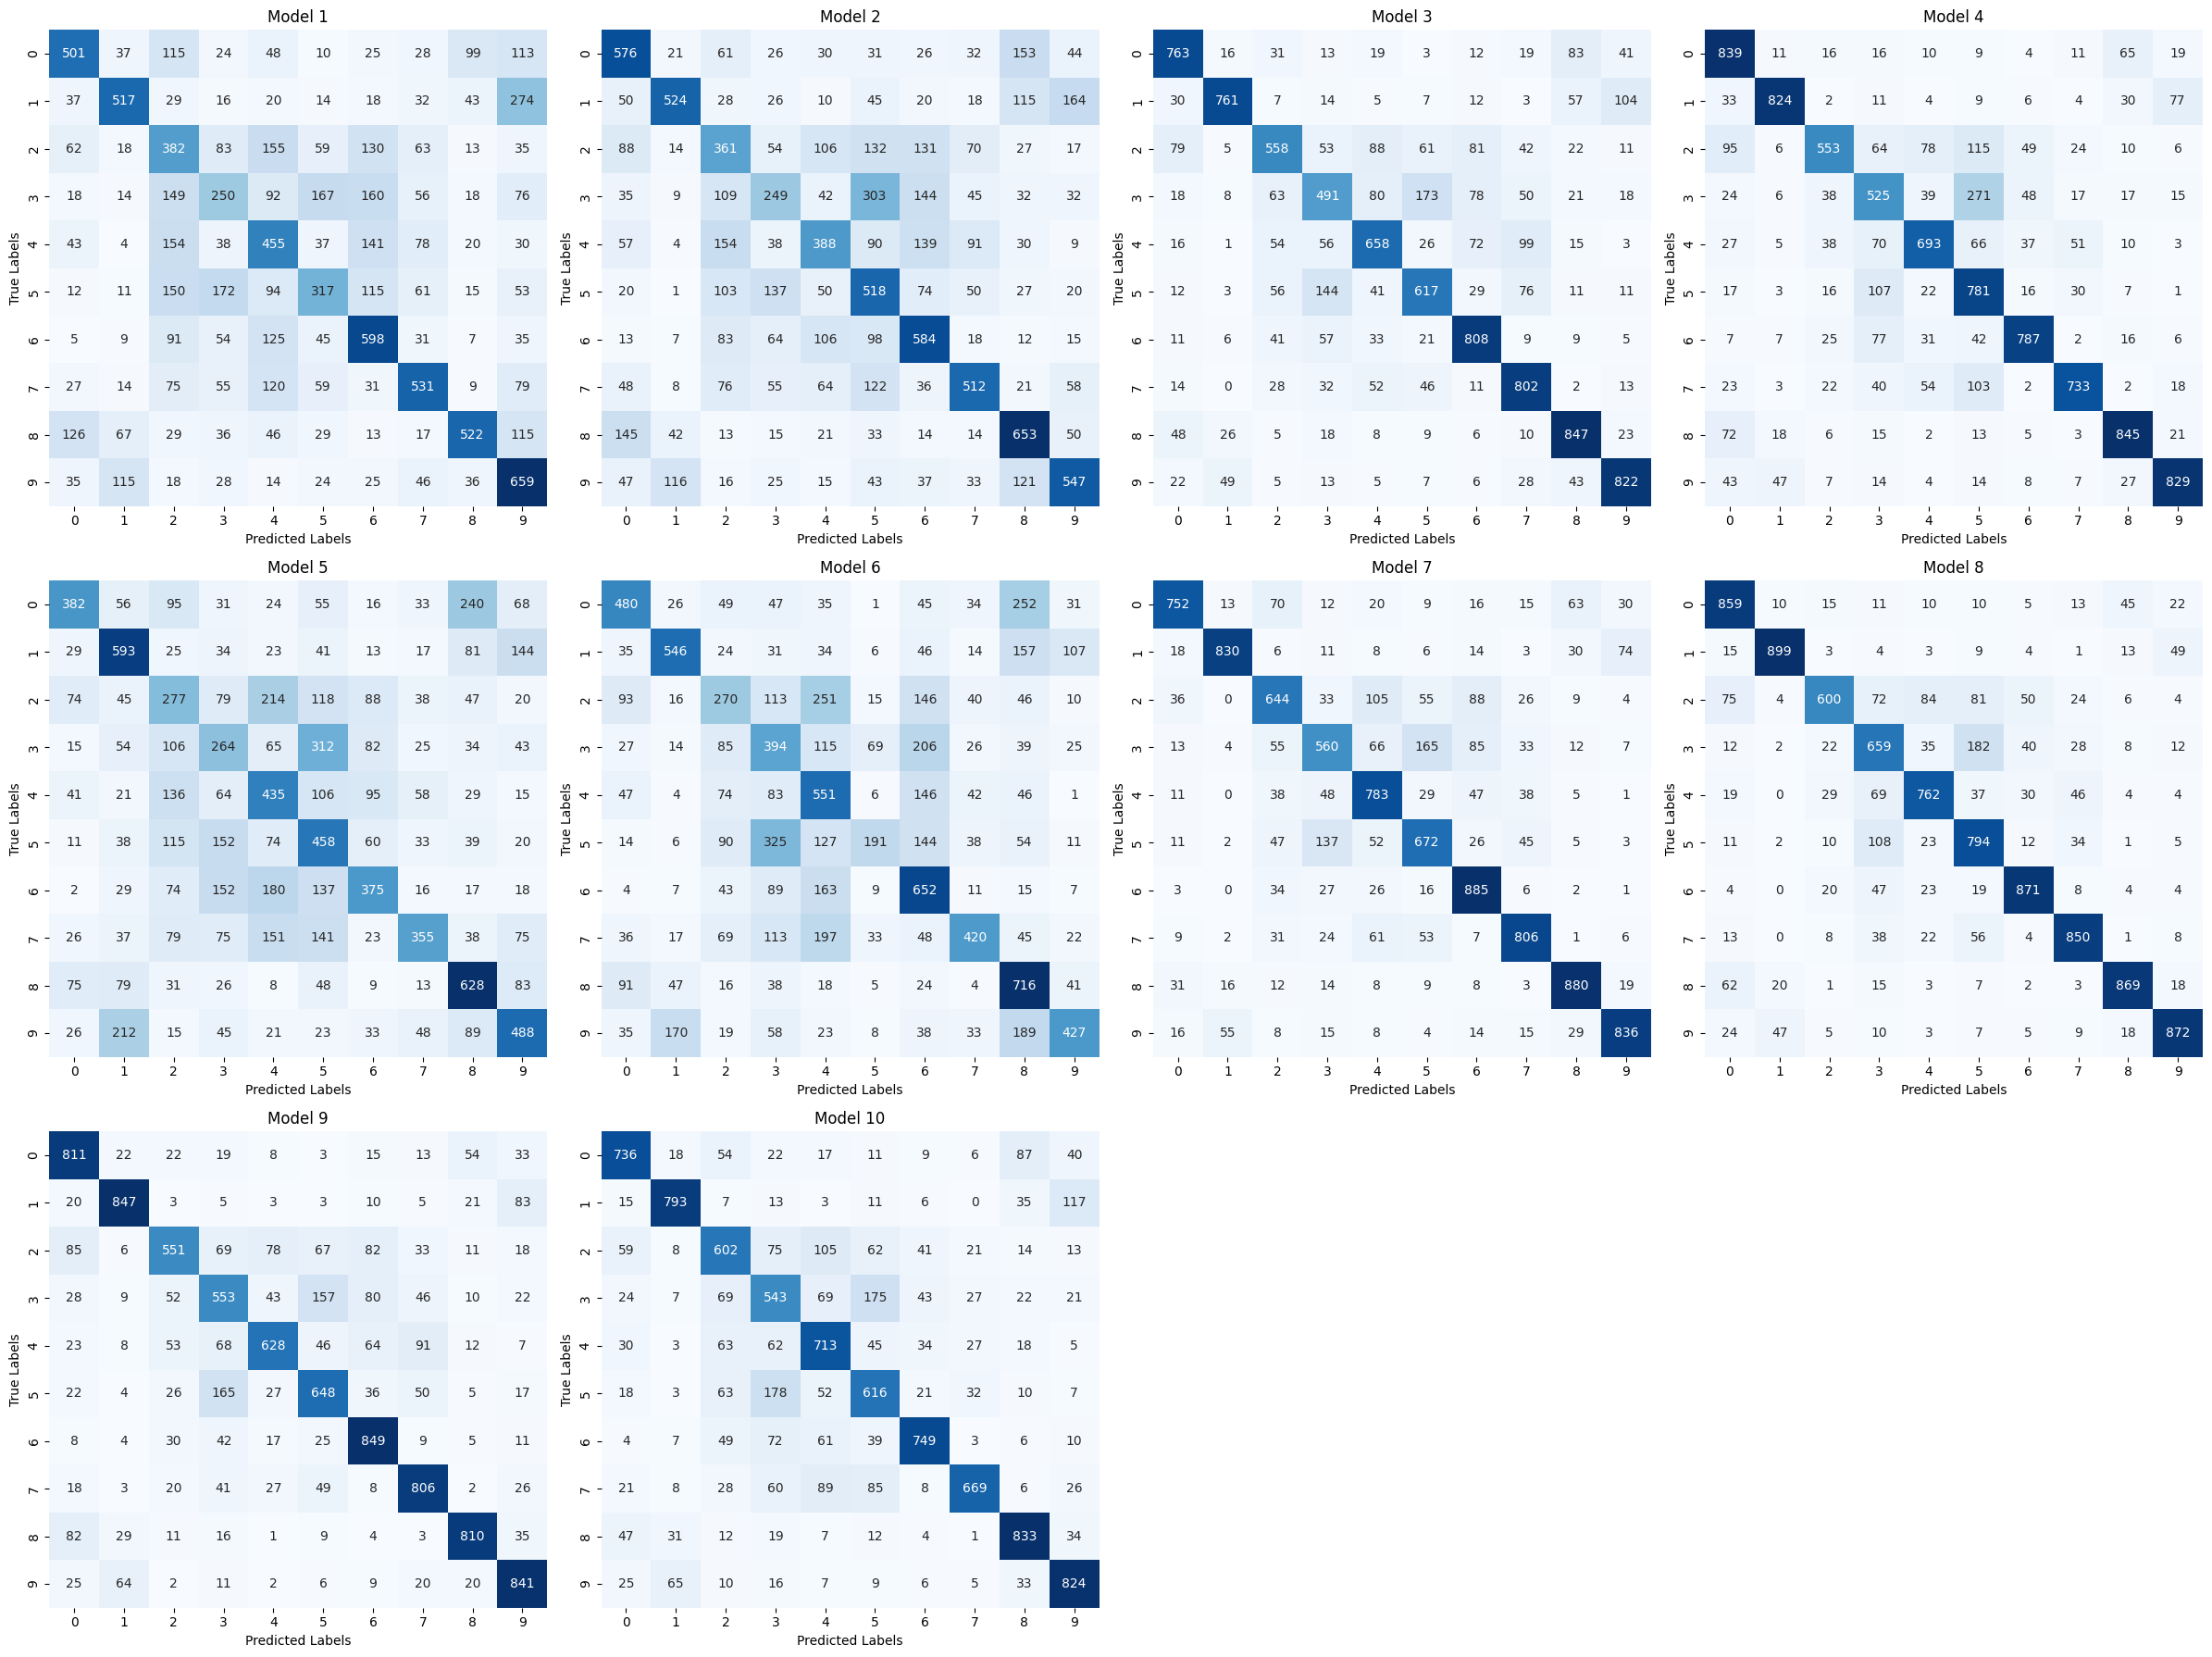

In [210]:
plot_confusion_matrices(
    [pred_one,
    pred_two,
    pred_three,
    pred_four,
    pred_five,
    pred_six,
    pred_seven,
    pred_eight,
    pred_nine,
    pred_ten]
    ,y_test
)

In [257]:
def plot_training_history(history_list,n):
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    # fig.suptitle('Training and Validation Accuracy and Loss', fontsize=16)

    for i, history in enumerate(history_list):
        row_idx = i // 4
        col_idx = i % 4

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training accuracy against validation accuracy
        axes[row_idx, col_idx].plot(training_accuracy, label='Training Accuracy')
        axes[row_idx, col_idx].plot(validation_accuracy, label='Validation Accuracy')
        axes[row_idx, col_idx].set_xlabel('Epochs')
        axes[row_idx, col_idx].set_ylabel('Accuracy')
        axes[row_idx, col_idx].set_title(f'Model {n + i + 1} Accuracy')
        axes[row_idx, col_idx].legend()

        # Plot training loss against validation loss
        axes[row_idx + 1, col_idx].plot(training_loss, label='Training Loss')
        axes[row_idx + 1, col_idx].plot(validation_loss, label='Validation Loss')
        axes[row_idx + 1, col_idx].set_xlabel('Epochs')
        axes[row_idx + 1, col_idx].set_ylabel('Loss')
        axes[row_idx + 1, col_idx].set_title(f'Model {n + i + 1} Loss')
        axes[row_idx + 1, col_idx].legend()

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


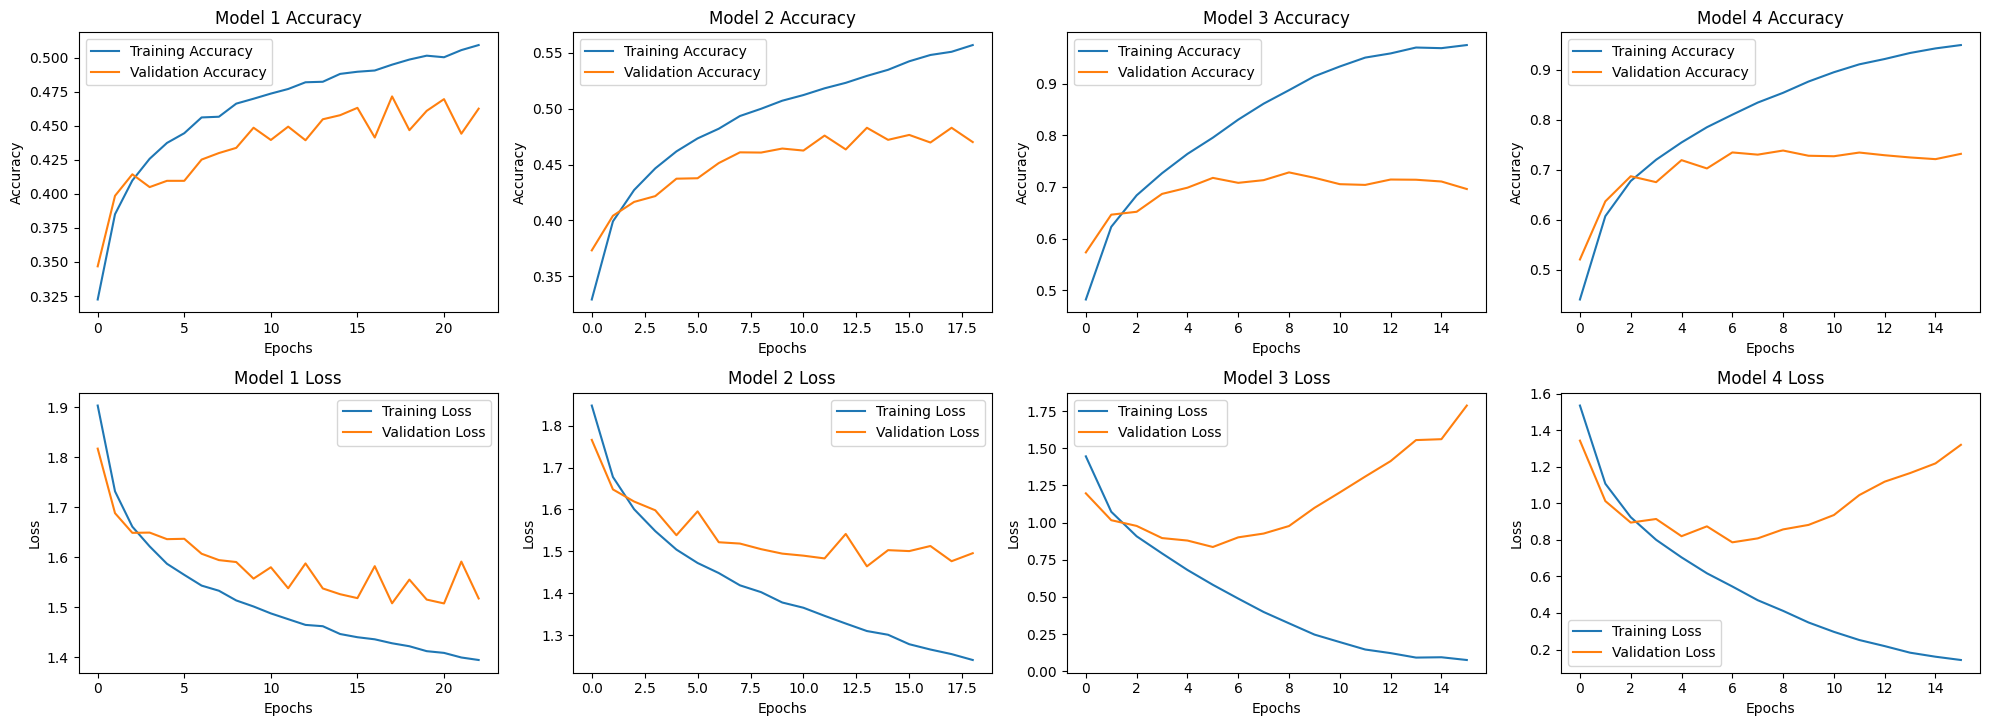

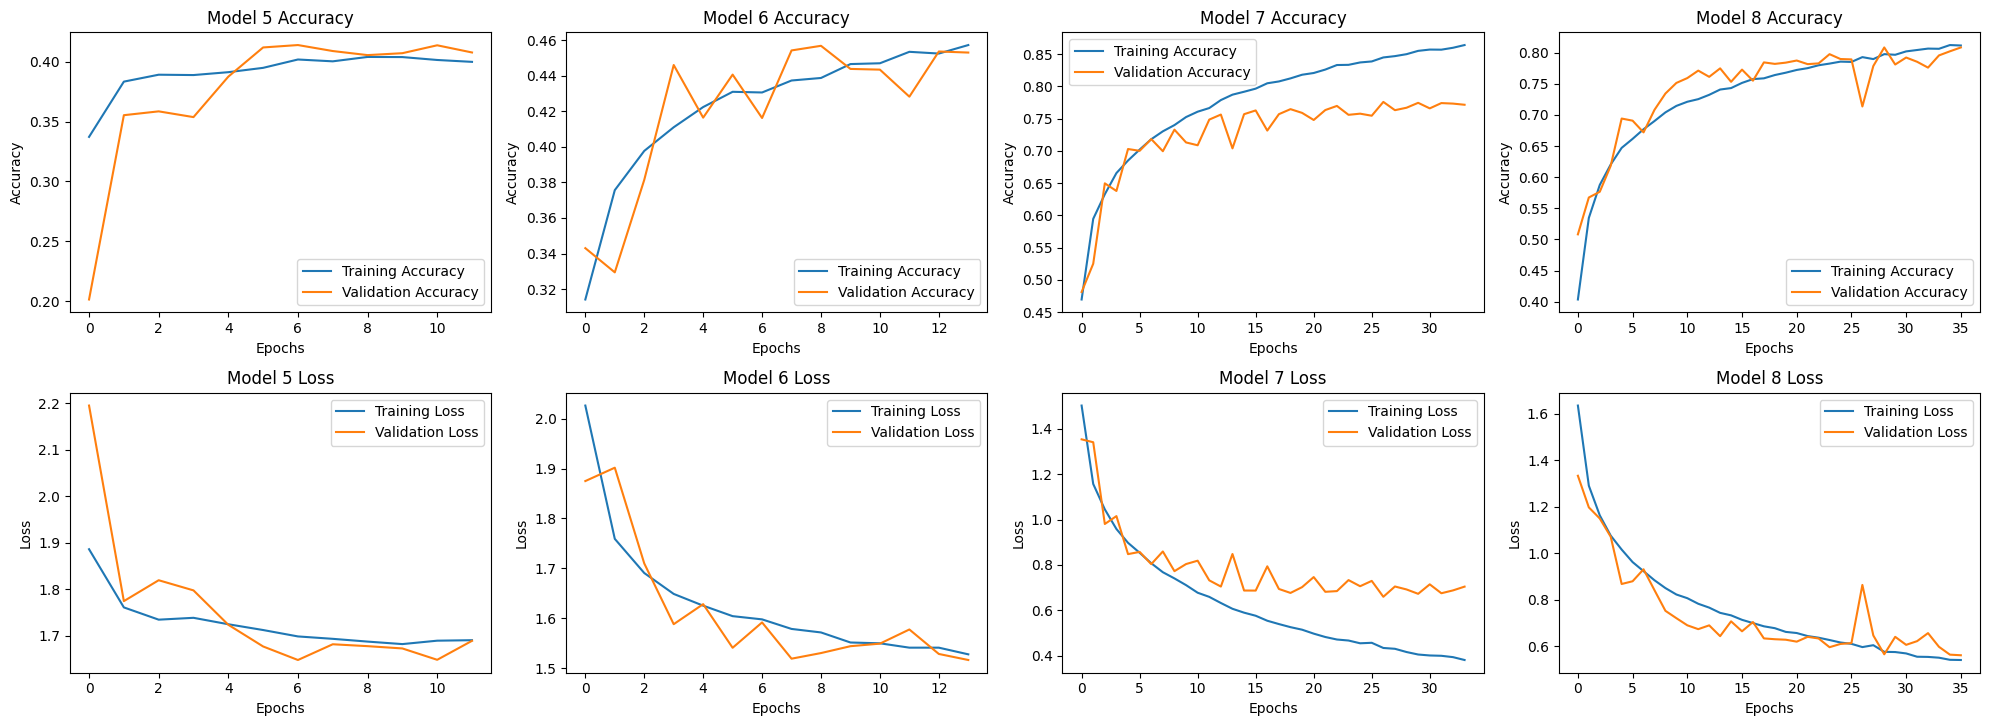

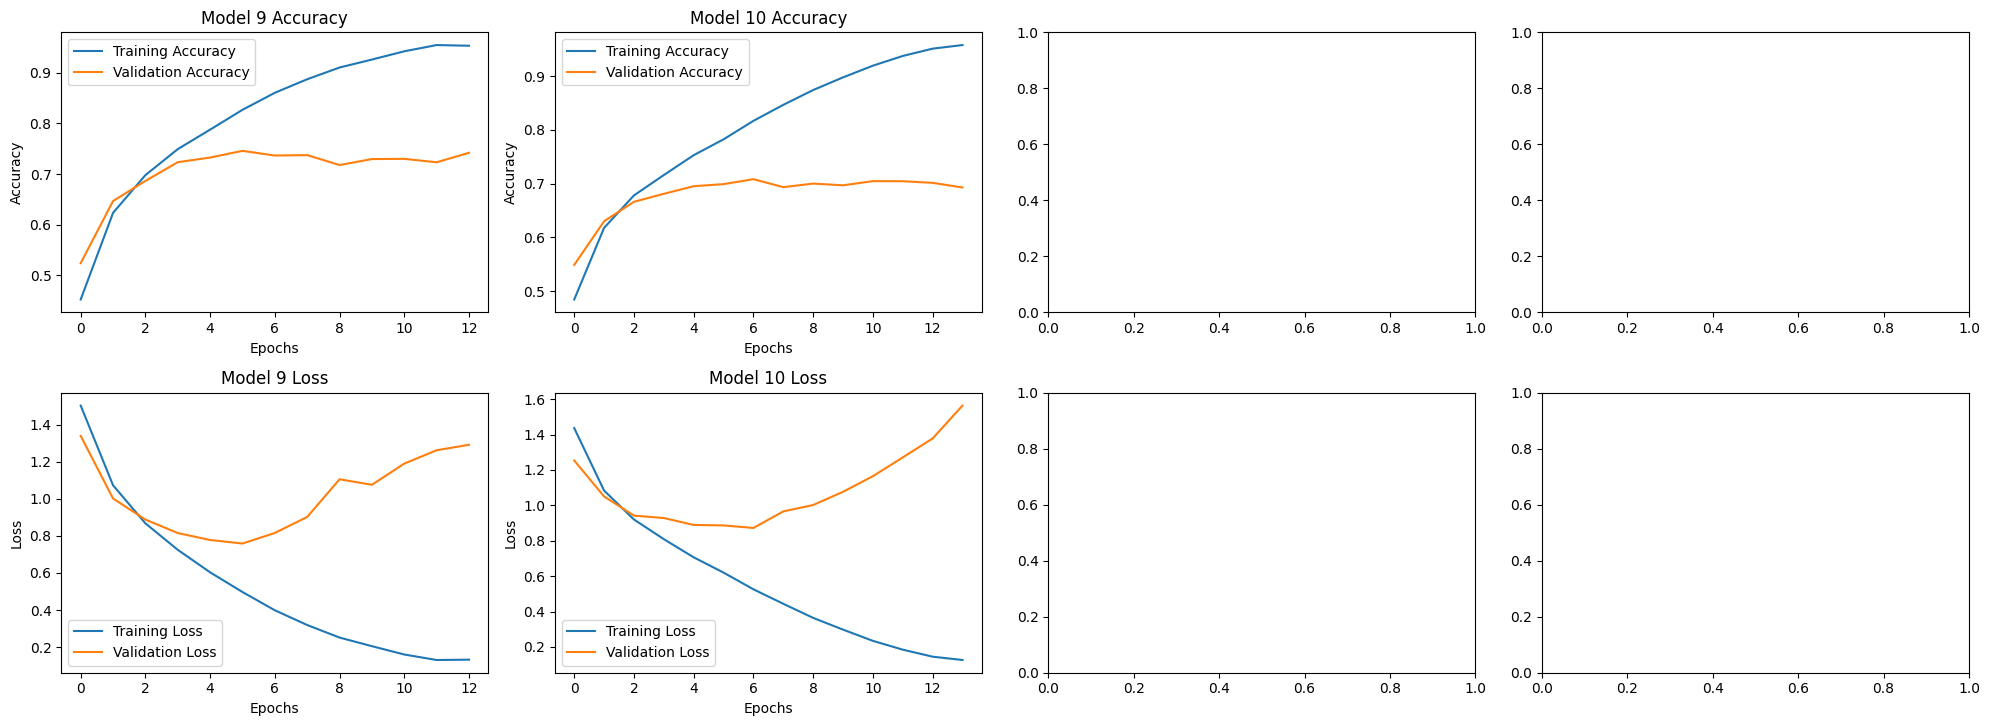

In [258]:
plot_training_history([training_one,training_two,training_three,training_four],0)
plot_training_history([training_five,training_six,training_seven,training_eight],4)
plot_training_history([training_nine,training_ten],8)

In [259]:
# TSNE

In [267]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

In [263]:
model = model_three

In [264]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:2000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

63/63 [==============================] - 0s 6ms/step


In [265]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.047009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.579788
[t-SNE] KL divergence after 300 iterations: 2.500263


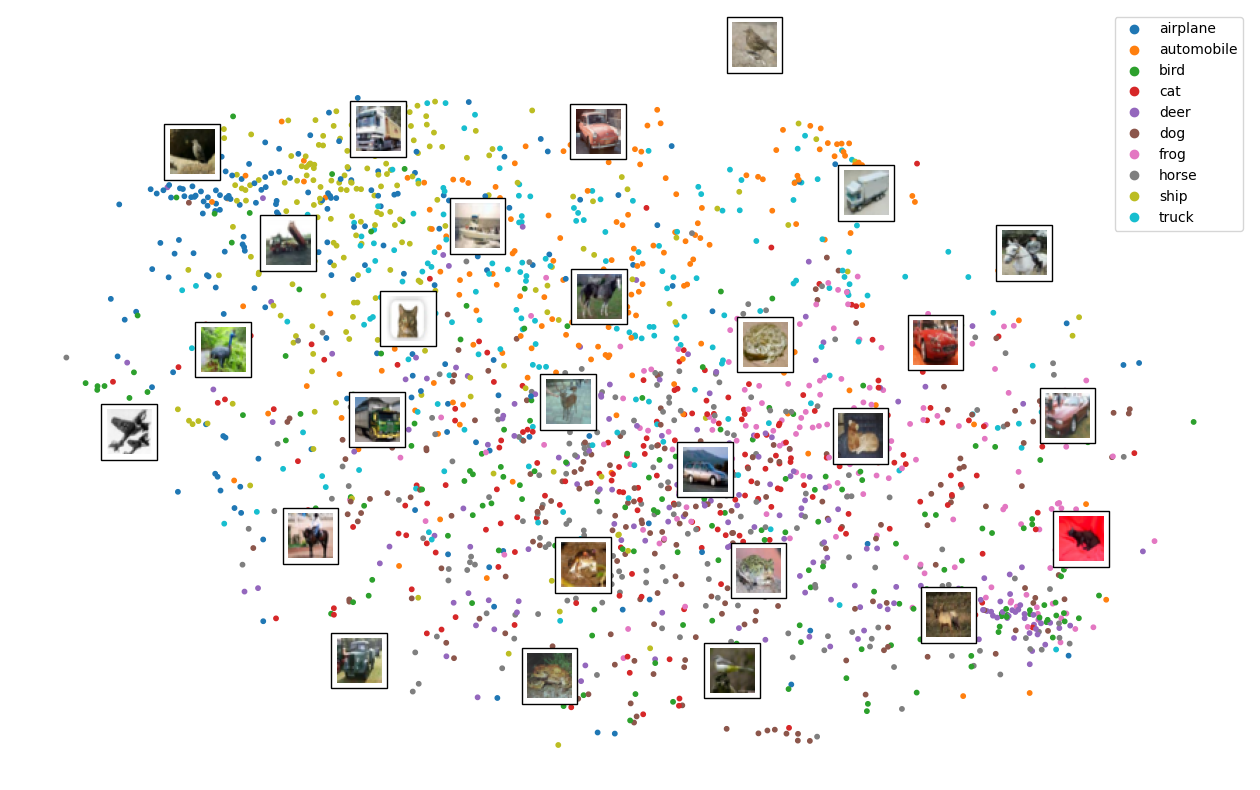

In [270]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()